In [1]:
import math 
import warnings 
warnings.filterwarnings('ignore')

from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate 
from qiskit.visualization import *

from qiskit_aer import AerSimulator

In [2]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

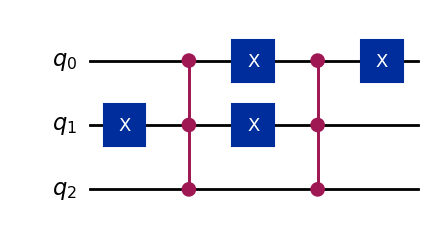

In [3]:
marked_states = ['101', '110']
oracle = grover_oracle(marked_states)
oracle.draw(output = 'mpl', style = 'iqp')

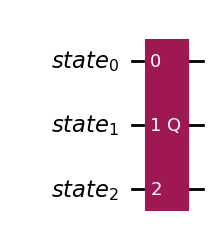

In [4]:
grover_op = GroverOperator(oracle)
grover_op.draw(output = 'mpl', style = 'iqp')

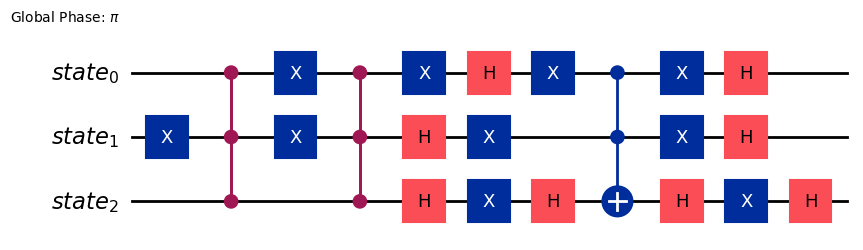

In [5]:
grover_op.decompose().draw(output = 'mpl', style = 'iqp')

In [6]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

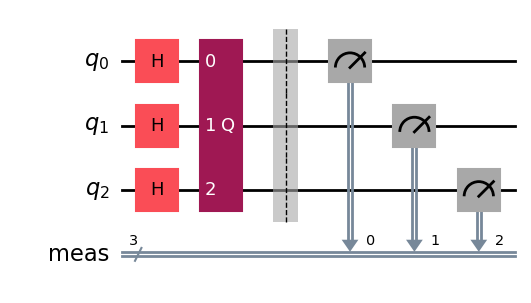

In [7]:
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output = 'mpl', style = 'iqp')

In [8]:
from qiskit_aer import AerSimulator
backend = AerSimulator(method = 'statevector')


# from qiskit.primitives import StatevectorSampler
# backend = StatevectorSampler()



In [9]:
# print(AerSimulator().available_methods())

In [10]:
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# target = 'qasm_simulator'
# pm = generate_preset_pass_manager(target=target, optimization_level=3)

# circuit_isa = pm.run(qc)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

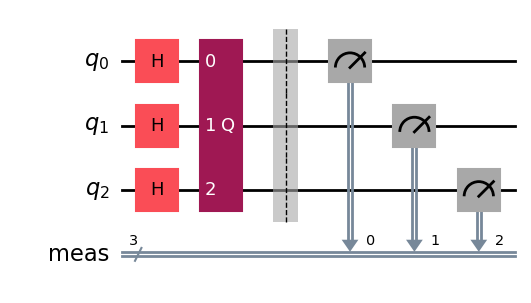

In [11]:
from qiskit import transpile
from qiskit.transpiler import PassManager

pm = PassManager()
transpiled_qc = pm.run(qc)
transpiled_qc.draw(output = 'mpl', style = 'iqp')


In [12]:
# # To run on local simulator:
# #   1. Use the SatetvectorSampler from qiskit.primitives instead
# # from qiskit.primitives import StatevectorSampler
# # sampler = StatevectorSampler()
# result = backend.run([circuit_isa]).result()
# dist = result.get_counts()

In [16]:
job = backend.run(qc, shots = 1024)
result = job.result()

AerError: 'unknown instruction: Q'

In [ ]:
result

PubResult(data=DataBin<>(meas=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'shots': 1024})

In [ ]:
result.data.meas.get_counts()

{'110': 539, '101': 485}

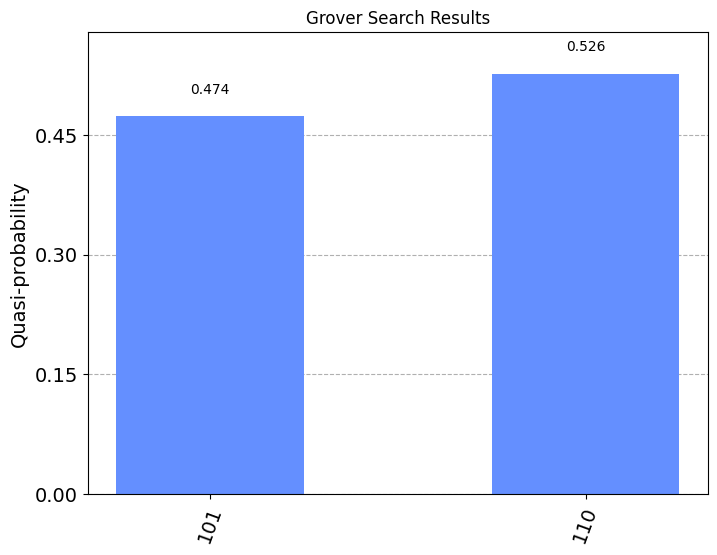

In [ ]:
plot_distribution(result.data.meas.get_counts(), title='Grover Search Results', figsize=(8, 6)   )